In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/aiffelton_git/70sEnt/"

/content/drive/MyDrive/aiffelton_git/70sEnt


# 00 package import

In [ ]:
!pip install statsmodels==0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 8.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np
import sys, os
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
sys.path.append(os.path.abspath('/content/drive/MyDrive/aiffelton_git/70sEnt/'))
from Preprocessing import data_preprocessing

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

# 01 Data load and preprocessing



In [ ]:
socar_file_path='/content/drive/MyDrive/00_Aiffelton/데이터/'
weather_file_path='/content/drive/MyDrive/00_Aiffelton/데이터/기상데이터/'
finedust_file_apth='/content/drive/MyDrive/00_Aiffelton/데이터/미세먼지/'
standard_time='time2'
location=None

In [ ]:
ts_df = data_preprocessing.timeseries_df_create_2(socar_file_path, weather_file_path, finedust_file_apth, standard_time,location)
regionBonB_ts_df = data_preprocessing.timeseries_df_create_2(socar_file_path, weather_file_path, finedust_file_apth, standard_time,'B지역')
regionCnC_ts_df = data_preprocessing.timeseries_df_create_2(socar_file_path, weather_file_path, finedust_file_apth, standard_time,'C지역')
regionDionD_ts_df = data_preprocessing.timeseries_df_create_2(socar_file_path, weather_file_path, finedust_file_apth, standard_time,'D지역')
regionAnA_ts_df = data_preprocessing.timeseries_df_create_2(socar_file_path, weather_file_path, finedust_file_apth, standard_time,'A지역')
regionE_ts_df = data_preprocessing.timeseries_df_create_2(socar_file_path, weather_file_path, finedust_file_apth, standard_time,'E지역')

In [ ]:
def seasonality_add(df):
  sd_24 = seasonal_decompose(df['count'], period=24)
  sd_168 = seasonal_decompose(df['count'] - np.array(sd_24.seasonal), period=168)
  df['24seasonal'] = sd_24.seasonal
  df['168seasonal'] = sd_168.seasonal
  df['residual'] = df['count'] - sd_24.seasonal - sd_168.seasonal

In [ ]:
seasonality_add(ts_df)
seasonality_add(regionB_ts_df)
seasonality_add(regionC_ts_df)
seasonality_add(regionD_ts_df)
seasonality_add(regionA_ts_df)
seasonality_add(regionE_ts_df)

## data 중 필요없는 칼럼 drop (쏘카 보안관련 코드 삭제)

# 02 Data set building

## timeseries variable dataset build

In [ ]:
def data_set_build(ts_df):
  column_len = len(ts_df.columns)-1
  inputs = ts_df.drop('count', axis=1).iloc[:-23].to_numpy()
  target = ts_df['count'].iloc[168:].to_numpy()
  standardscaler_1 = StandardScaler()
  standardscaler_1.fit(inputs)
  inputs = standardscaler_1.transform(inputs)

  # # min_max_scaler
  # min_max_scaler = MinMaxScaler((0,1))
  # inputs = min_max_scaler.fit_transform(inputs)

  # min_max_scaler = MinMaxScaler((0,1))
  # target = min_max_scaler.fit_transform(target.reshape((-1,1)))

  standardscaler_2 = StandardScaler()
  standardscaler_2.fit(target.reshape((-1,1)))
  target = standardscaler_2.transform(target.reshape((-1,1)))
  target = target.reshape((-1))

  inputs_df = np.zeros((len(inputs[:-168]),168,column_len))
  for i in range(len(inputs_df)):
    inputs_df[i]=inputs[i:i+168].reshape(1,168,column_len)

  target_df = []
  for i in range(len(target))[:-23]:
    data_1 = [x for x in target[i:i+24]]
    target_df.append(data_1)
  
  first = True
  i=0
  while i*24*7*6+24*7*5-23<=len(inputs_df):
    i+=1
    if first:
      x_train = inputs_df[:24*7*3-23]
      y_train = target_df[:24*7*3-23]
      x_test = inputs_df[24*7*4:24*7*5-23]
      y_test = target_df[24*7*4:24*7*5-23]
      first = False
    else:
      x_train = np.concatenate((x_train,inputs_df[24*7*6*i:24*7*6*i+24*7*3-23]))
      y_train = np.concatenate((y_train,target_df[24*7*6*i:24*7*6*i+24*7*3-23]))
      x_test = np.concatenate((x_test,inputs_df[24*7*6*i + 24*7*4:24*7*6*i + 24*7*5-23]))
      y_test = np.concatenate((y_test,target_df[24*7*6*i + 24*7*4:24*7*6*i + 24*7*5-23]))
    
  return x_train,y_train,x_test,y_test,standardscaler_1,standardscaler_2

In [ ]:
regionB_x_train,regionB_y_train,regionB_x_test,regionB_y_test,regionB_standardscaler_1,regionB_standardscaler_2 =  data_set_build(regionB_ts_df)
regionC_x_train,regionC_y_train,regionC_x_test,regionC_y_test,regionC_standardscaler_1,regionC_standardscaler_2 =  data_set_build(regionC_ts_df)
regionD_x_train,regionD_y_train,regionD_x_test,regionD_y_test,regionD_standardscaler_1,regionD_standardscaler_2 =  data_set_build(regionD_ts_df)
regionA_x_train,regionA_y_train,regionA_x_test,regionA_y_test,regionA_standardscaler_1,regionA_standardscaler_2 =  data_set_build(regionA_ts_df)
regionE_x_train,regionE_y_train,regionE_x_test,regionE_y_test,regionE_standardscaler_1,regionE_standardscaler_2 =  data_set_build(regionE_ts_df)

## 02 - 02 static variable dataset build

In [ ]:
# 연령대 비율
age_df = pd.read_csv('/content/drive/MyDrive/00_Aiffelton/데이터/연령대별비율.csv',index_col=0)

In [ ]:
age_df.columns=['age_20','age_30','age_40','age_50','age_60']

In [ ]:
# 성비 비율
gender_df = pd.read_csv('/content/drive/MyDrive/00_Aiffelton/데이터/성비.csv',index_col = 0)

In [ ]:
gender_df.columns=['woman_rate','man_rate']

In [ ]:
# 자동차 연령별 소유율
car_df = pd.read_csv('/content/drive/MyDrive/00_Aiffelton/데이터/자동차소유율연령구군별.csv',encoding='cp949',sep = '\t',index_col = 0).T

In [ ]:
car_df.columns  = ['car_rate_20','car_rate_30','car_rate_40','car_rate_50','car_rate_60']

In [ ]:
car_df = car_df.rename(index ={"A지역연령별소유율":"A지역","B지역연령별소유율":"B지역","C지역연령별소유율":"C지역","D지역연령별소유율":"D지역","E지역연령별소유율":"E지역"})

In [ ]:
# 대학 학사일정
uni_df = pd.read_csv('/content/drive/MyDrive/00_Aiffelton/데이터/calendar_univ.csv',index_col = 0)

In [ ]:
location = 'A지역'
index1 = [x for x in age_df.index.values if x.startswith(location)].pop()
index2 = [x for x in gender_df.index.values if x.startswith(location)].pop()
index3 = [x for x in car_df.index.values if x.startswith(location)].pop()

In [ ]:
x_train_over_static = np.concatenate((age_df.loc[index1].values,gender_df.loc[index2].values,car_df.loc[index3].values))
x_train_over_static

array([16.85097934, 17.22344793, 21.16211764, 24.30250078, 20.46095431,
       49.01733562, 50.98266438,  1.620084  ,  8.360746  , 14.652496  ,
       19.204109  , 13.720462  ])

# 03 Model Build

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, Concatenate, Dense,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow.keras.backend as K




In [ ]:
from tensorflow.keras.utils import get_custom_objects

In [ ]:
from tensorflow.keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

leaky_relu = tf.keras.layers.LeakyReLU

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [ ]:
# Define timesteps and the number of features
n_timesteps = 168
n_features = 10
n_outputs = 24
# RNN + SLP Model
# Define input layer
recurrent_input = Input(shape=(n_timesteps,n_features),name="TIMESERIES_INPUT")
static_input = Input(shape=(x_train_over_static.shape[0], ),name="STATIC_INPUT")
# RNN Layers
# layer - 1
rec_layer_one = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),return_sequences=True),name ="BIDIRECTIONAL_LAYER_1")(recurrent_input)
rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
# layer - 2
rec_layer_two = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)
# SLP Layers
static_layer_one = Dense(64,  kernel_regularizer=l2(0.001),  activation='relu',name="DENSE_LAYER_1")(static_input)
# Combine layers - RNN + SLP
combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two,static_layer_one])

# swish 설정
#combined_dense_two = Dense(64, activation='custom_activation',name="DENSE_LAYER_2")(combined)

# leaky relu 설정
combined_dense_two = Dense(64,name="DENSE_LAYER_2")(combined)
combined_dense_two_activation = LeakyReLU()(combined_dense_two)

output = Dense(n_outputs,activation='tanh',name="OUTPUT_LAYER")(combined_dense_two_activation)
# Compile ModeL
model = Model(inputs=[recurrent_input,static_input],outputs=[output])
# binary cross entropy loss
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# focal loss
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 168, 10)]    0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (Bidirec  (None, 168, 256)    142336      ['TIMESERIES_INPUT[0][0]']       
 tional)                                                                                          
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 168, 256)     0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (Bidirec  (None, 128)         164352      ['DROPOUT_LAYER_1[0][0]']    

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001)

# 04 Model train

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(
      [np.asarray(x_train).astype('float32'), np.asarray(np.repeat([x_train_over_static],len(x_train),0)).astype('float32')],
      y_train,
      epochs=600,
      validation_split = 0.2,
      callbacks=[reduce_lr]
      )

In [ ]:
model.save("regionE_base_season_first.h5")

# 05 Model result analysis

In [ ]:
def mape(a, f): #(test,pred)
    return np.mean(np.abs((a-f)/(a+1e-10)))*100


In [ ]:
def mae(a,f):
  return np.abs((a - f)).mean()

In [ ]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/00_Aiffelton/베이스라인/regionE_base_season_first.h5")

In [ ]:
y_hat = model.predict([np.asarray(regionE_x_test).astype('float32'), np.asarray(np.repeat([x_train_over_static],len(regionE_x_test),0)).astype('float32')])

In [ ]:
y_hat = regionE_standardscaler_2.inverse_transform(y_hat)
y_test = regionE_standardscaler_2.inverse_transform(np.asarray(regionE_y_test))

In [ ]:
mape(y_test,y_hat)

47.49833546410155

In [ ]:
mae(y_test,y_hat)

6.525477618811282

In [ ]:
y_test_before =pd.DataFrame(y_test[-169:-1,0])
y_test_before.index = np.arange(-168,0,1)

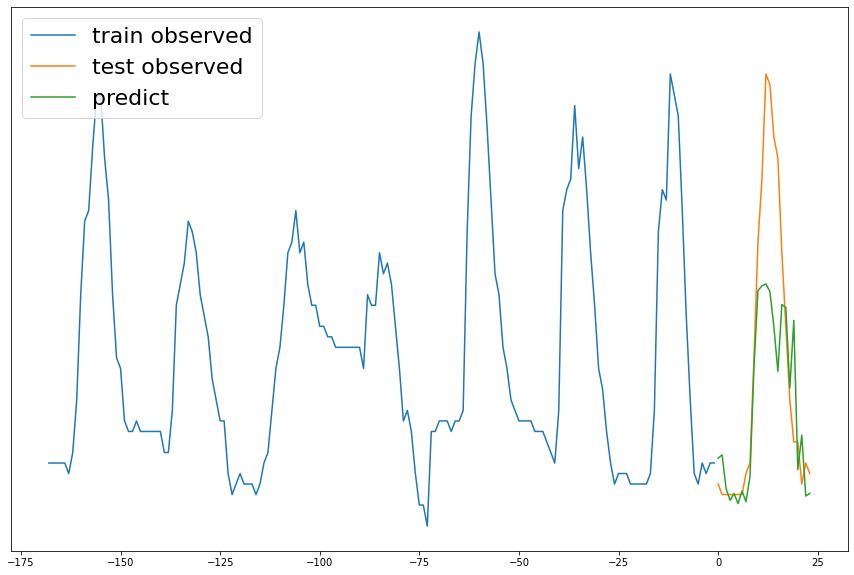

In [ ]:
fig = plt.figure(figsize=(15,10))

a = plt.plot(y_test_before,label = "train observed")
b = plt.plot(y_test[-1,:],label ="test observed")
c = plt.plot(y_hat[-1,:],label = "predict")


# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)
plt.yticks([])
plt.legend(fontsize=22,loc=2)